In [1]:
from sqlalchemy import create_engine
import pandas as pd

from paths import HERE

DB_PATH = "/home/vaunorage/PycharmProjects/clear/ClearBias/experiment_results.db"
conn = create_engine(f'sqlite:///{DB_PATH}')


In [ ]:
query = """
WITH results_union AS (
    SELECT
        model_scores,
        group_key,
        couple_tpr,
        couple_fpr,
        group_size,
        nb_attributes,
        nb_groups,
        granularity,
        intersectionality,
        similarity,
        alea_uncertainty,
        epis_uncertainty,
        magnitude,
        frequency,
        COUNT(CASE WHEN diff_outcome_y IS NOT NULL AND diff_outcome_x > 0 THEN 1 ELSE NULL END) OVER (PARTITION BY model_scores, group_key) AS number_of_found_cases,
        COUNT(CASE WHEN diff_outcome_x > 0 THEN 1 ELSE NULL END) OVER (PARTITION BY model_scores, group_key) AS partition_size
    FROM
        results_optuna
    UNION ALL
    SELECT
        model_scores,
        group_key,
        couple_tpr,
        couple_fpr,
        group_size,
        nb_attributes,
        nb_groups,
        granularity,
        intersectionality,
        similarity,
        alea_uncertainty,
        epis_uncertainty,
        magnitude,
        frequency,
        COUNT(CASE WHEN diff_outcome_y IS NOT NULL AND diff_outcome_x > 0 THEN 1 ELSE NULL END) OVER (PARTITION BY model_scores, group_key) AS number_of_found_cases,
        COUNT(CASE WHEN diff_outcome_x > 0 THEN 1 ELSE NULL END) OVER (PARTITION BY model_scores, group_key) AS partition_size
    FROM
        results4
)
SELECT
    distinct 
    model_scores,
    group_key,
    couple_tpr,
    couple_fpr,
    group_size,
    nb_attributes,
    nb_groups,
    granularity,
    intersectionality,
    similarity,
    1-alea_uncertainty,
    1-epis_uncertainty,
    magnitude,
    1-frequency,
    number_of_found_cases,
    partition_size,
    CAST(number_of_found_cases AS FLOAT) / partition_size AS ratio_of_found_cases
FROM
    results_union;
"""

df = pd.read_sql_query(query, conn)
df

In [ ]:
import json
df['model_type'] = df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))['model'] if isinstance(x, str) else x)
df['mod_score'] = 1-df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))['score'] if isinstance(x, str) else x)


In [ ]:
# Assuming df is predefined and already imported
dff = df[df['ratio_of_found_cases']>0]


In [ ]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()
properties = [
    'nb_attributes', 'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    axes[i].scatter(dff[prop], dff['ratio_of_found_cases'])
    axes[i].set_title(f'Trend of {prop}')
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('Count of Found Cases')

plt.tight_layout()
plt.savefig('figuree1.png')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def bin_and_statistics(data, k):
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2-dimensional array with shape (N, 2)")

    # Dynamically set k based on the unique values in the property
    unique_values = len(np.unique(data[:, 0]))
    k = min(k, unique_values)
    if k < 1:
        k = 1  # Ensure at least one bin

    min_val = np.min(data[:, 0])
    max_val = np.max(data[:, 0])
    
    bins = np.linspace(min_val, max_val, k + 1)
    bin_indices = np.digitize(data[:, 0], bins, right=True)
    
    # Statistics arrays
    medians = np.zeros(k)
    first_quartiles = np.zeros(k)
    third_quartiles = np.zeros(k)
    
    for i in range(1, k + 1):
        bin_elements = data[bin_indices == i, 1]
        
        if bin_elements.size > 0:
            medians[i - 1] = np.median(bin_elements)
            first_quartiles[i - 1] = np.percentile(bin_elements, 25)
            third_quartiles[i - 1] = np.percentile(bin_elements, 75)
        else:
            medians[i - 1] = np.nan  # Use NaN for empty bins
            first_quartiles[i - 1] = np.nan
            third_quartiles[i - 1] = np.nan

    return bins, medians, first_quartiles, third_quartiles

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()

properties = [
    'nb_attributes',
    'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    if pd.api.types.is_numeric_dtype(dff[prop]):  # Check if the property is numeric
        data = dff[[prop, 'ratio_of_found_cases']].dropna().to_numpy()
        if data.size == 0:
            continue  # Skip if no data to plot
        bins, medians, first_quartiles, third_quartiles = bin_and_statistics(data, 10)
        bin_midpoints = (bins[:-1] + bins[1:]) / 2

        # Plotting median line
        axes[i].plot(bin_midpoints, medians, color='red', label='Median')
        # Plotting the uncertainty area between the first and third quartiles
        axes[i].fill_between(bin_midpoints, first_quartiles, third_quartiles, color='gray', alpha=0.5, label='Interquartile Range')

        axes[i].set_title(f'Trend of {prop}')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Count of Non-Null diff_outcome_y')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'Non-numeric data: {prop}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Trend of {prop}')

plt.tight_layout()
plt.savefig('figuree2.png')
plt.show()


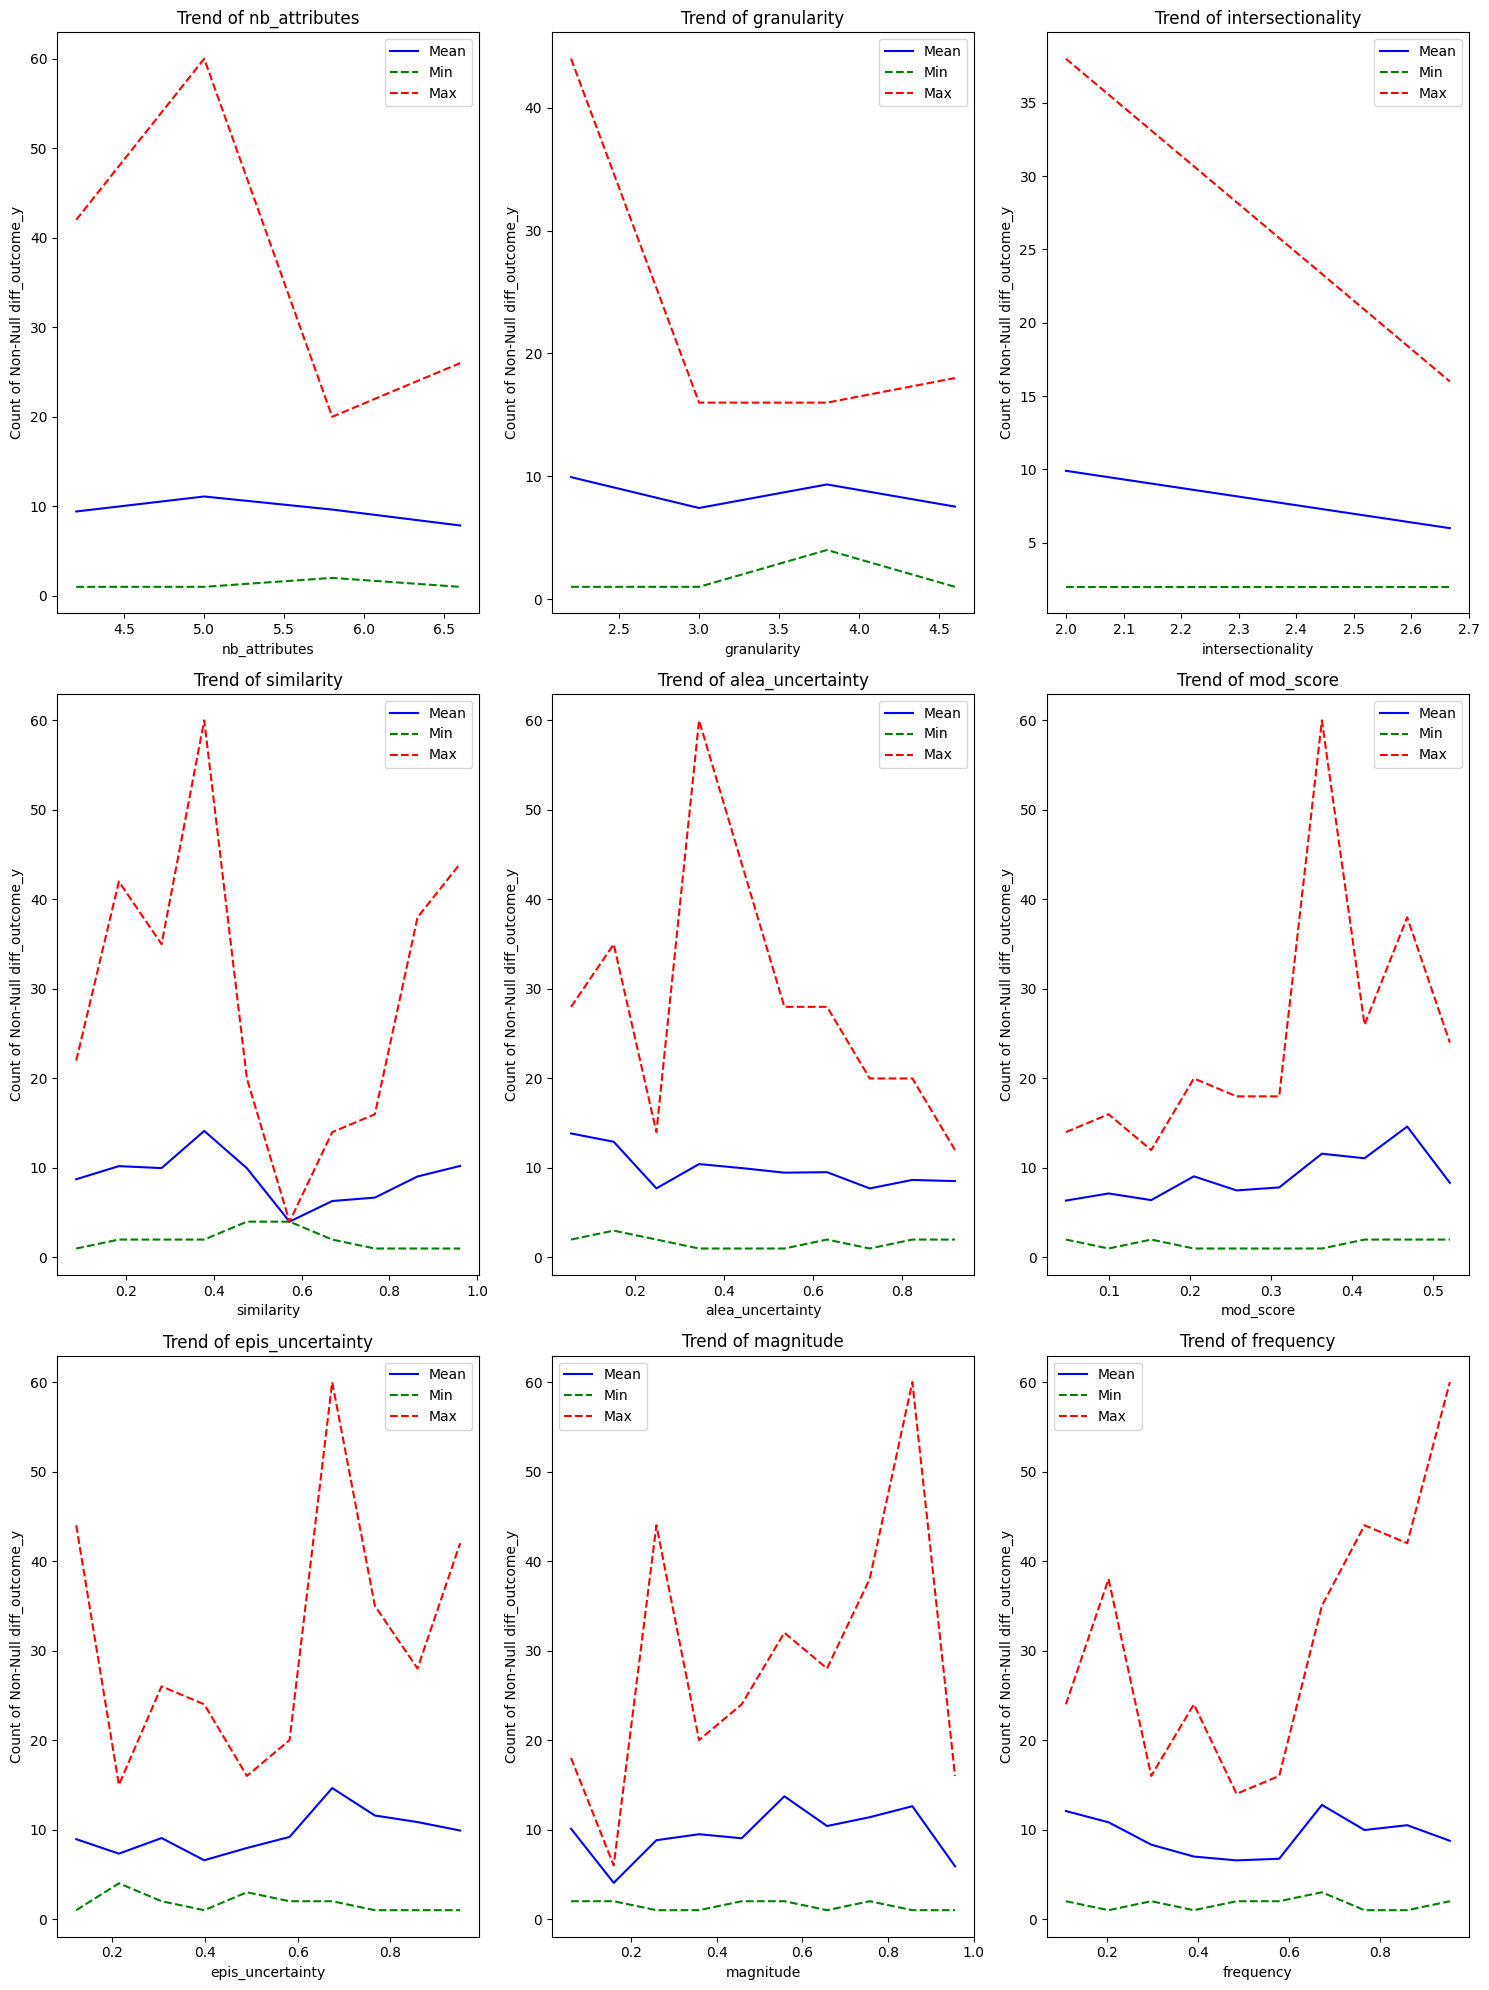

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bin_and_statistics(data, k):
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2-dimensional array with shape (N, 2)")

    unique_values = len(np.unique(data[:, 0]))
    k = min(k, unique_values)
    if k < 1:
        k = 1  # Ensure at least one bin

    min_val = np.min(data[:, 0])
    max_val = np.max(data[:, 0])
    
    bins = np.linspace(min_val, max_val, k + 1)
    bin_indices = np.digitize(data[:, 0], bins, right=True)
    
    # Statistics arrays
    means = np.zeros(k)
    mins = np.zeros(k)
    maxs = np.zeros(k)
    
    for i in range(1, k + 1):
        bin_elements = data[bin_indices == i, 1]
        
        if bin_elements.size > 0:
            means[i - 1] = np.mean(bin_elements)
            mins[i - 1] = np.min(bin_elements)
            maxs[i - 1] = np.max(bin_elements)
        else:
            means[i - 1] = np.nan  # Use NaN for empty bins
            mins[i - 1] = np.nan
            maxs[i - 1] = np.nan

    return bins, mins, means, maxs

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()

properties = [
    'nb_attributes', 'granularity', 'intersectionality', 'similarity',
    'alea_uncertainty', 'mod_score', 'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    if pd.api.types.is_numeric_dtype(dff[prop]):
        data = dff[[prop, 'number_of_found_cases']].dropna().to_numpy()
        if data.size == 0:
            continue
        bins, mins, means, maxs = bin_and_statistics(data, 10)
        bin_midpoints = (bins[:-1] + bins[1:]) / 2

        # Plotting mean line
        axes[i].plot(bin_midpoints, means, color='blue', label='Mean')
        # Plotting min and max lines
        axes[i].plot(bin_midpoints, mins, color='green', linestyle='--', label='Min')
        axes[i].plot(bin_midpoints, maxs, color='red', linestyle='--', label='Max')

        axes[i].set_title(f'Trend of {prop}')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Count of Non-Null diff_outcome_y')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'Non-numeric data: {prop}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Trend of {prop}')

plt.tight_layout()
plt.savefig('updated_figure.png')
plt.show()
